In [14]:
import warnings
warnings.filterwarnings("ignore")

In [1187]:
import sqlite3
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import dateparser  

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, silhouette_score, roc_curve
from sklearn.neighbors import NearestNeighbors

from pymorphy3 import MorphAnalyzer
from gensim.models import Word2Vec

import re
import nltk
from nltk.corpus import stopwords

In [203]:
DB_FILE = "articles.sqlite"

conn = sqlite3.connect(DB_FILE)

df = pd.read_sql_query("SELECT * FROM articles;", conn)

conn.close()

In [205]:
RANDOM_STATE = 42

In [207]:
df = df.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

In [209]:
df

,id,guid,title,description,url,published_at,comments_count,created_at_utc,rating
0,1505,fef4ca79-8f45-4bd3-8113-ca2f7606a699,AMD и Intel укрепили позиции на рынке видеокар...,Доля Intel впервые достигла 1%.\n\nJon Peddie ...,https://ixbt.games/news/2025/12/02/amd-i-intel...,2025-12-02T00:00:00,NaN,1765456246,NaN
1,539,f03f799a-f077-40f7-a3dd-cbbe359cb3e6,DeepSeek представила модели V3.2 и V3.2-Specia...,Китайский стартап DeepSeek выпустил очередное ...,https://habr.com/ru/news/972042/,2025-12-01T11:43:25+00:00,20.0,1765454398,7.0
2,3553,1562e574-2f81-471d-bcc9-f75600f688c0,В Ереване арестован глава канцелярии духовного...,Правительство Армении поможет в разработке нов...,https://www.interfax.ru/world/1061592,2025-12-05T11:05:00,NaN,1765460830,NaN
3,4948,fc71aea7-8759-4ac2-802c-f0b4b67b59b1,Вторую городскую штрафстоянку Владивостока обо...,Администрация Владивостока ищет подрядчика для...,https://www.newsvl.ru/vlad/2025/10/17/234577/,"16:42, 17 октября 2025",NaN,1765463255,NaN
4,4819,36c3e6af-5b48-46c2-a78f-f5f1925402d9,В ночь на понедельник во Владивостоке возможен...,В начале следующей недели погодные условия в П...,https://www.newsvl.ru/vlad/2025/10/26/234734/,"18:59, 26 октября 2025",NaN,1765463072,NaN
...,...,...,...,...,...,...,...,...,...
5017,4427,f577c65d-8162-468d-a5e1-ea1170d323a5,Закрытую горнолыжку «Синяя сопка» в Артёме рас...,С преобразованием горнолыжной базы в Арсеньеве...,https://www.newsvl.ru/vlad/2025/11/19/235185/,"17:13, 19 ноября 2025",NaN,1765462517,NaN
5018,467,c52fcff6-04e6-402e-b48a-6e2f96353431,Утечка «Soul doc»: пользователь извлёк из Clau...,В длинном посте на LessWrong один из пользоват...,https://habr.com/ru/companies/bothub/news/972570/,2025-12-02T16:42:58+00:00,0.0,1765454285,2.0
5019,3093,603b8c42-f483-48d1-8962-51ac4b7ce3e2,"Историк технологий объяснил, почему бесполезно...",Так называемый «искусственный интеллект» стал ...,https://naked-science.ru/article/hi-tech/oshib...,2025-12-14T08:27:00,1.0,1765459462,6.1
5020,3773,33199580-a8fb-4859-a499-e82aec52fc14,"Макрон считает, что без европейцев невозможно ...",Макрон призвал Си Цзиньпина совместно способст...,https://www.interfax.ru/world/1060873,2025-12-01T19:41:00,NaN,1765461414,NaN


In [211]:
df["published_at"].unique()

array(['2025-12-02T00:00:00', '2025-12-01T11:43:25+00:00',
       '2025-12-05T11:05:00', ..., '2025-12-14T08:27:00',
       '2025-12-01T19:41:00', '2025-11-25T07:13:23+00:00'], dtype=object)

In [213]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5022 entries, 0 to 5021
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              5022 non-null   int64  
 1   guid            5022 non-null   object 
 2   title           5022 non-null   object 
 3   description     5022 non-null   object 
 4   url             5022 non-null   object 
 5   published_at    5022 non-null   object 
 6   comments_count  1472 non-null   float64
 7   created_at_utc  5022 non-null   int64  
 8   rating          2037 non-null   float64
dtypes: float64(2), int64(2), object(5)
memory usage: 353.2+ KB


In [215]:
df.isna().sum()

id                   0
guid                 0
title                0
description          0
url                  0
published_at         0
comments_count    3550
created_at_utc       0
rating            2985
dtype: int64

In [217]:
def custom_published_parser(x):
    if pd.isna(x):
        return pd.NaT
    s = str(x).strip()

    try:
        return pd.to_datetime(s, utc=True)
    except Exception:
        pass

    dt = dateparser.parse(
        s,
        languages=["ru"],
        settings={"RETURN_AS_TIMEZONE_AWARE": True, "TIMEZONE": "UTC"}
    )
    return pd.to_datetime(dt) if dt else pd.NaT

In [219]:
df["published_at"] = df["published_at"].apply(custom_parser)

df['created_at_utc'] = pd.to_datetime(df['created_at_utc'], unit='s', utc=True)

In [221]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5022 entries, 0 to 5021
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   id              5022 non-null   int64              
 1   guid            5022 non-null   object             
 2   title           5022 non-null   object             
 3   description     5022 non-null   object             
 4   url             5022 non-null   object             
 5   published_at    5022 non-null   datetime64[ns, UTC]
 6   comments_count  1472 non-null   float64            
 7   created_at_utc  5022 non-null   datetime64[ns, UTC]
 8   rating          2037 non-null   float64            
dtypes: datetime64[ns, UTC](2), float64(2), int64(1), object(4)
memory usage: 353.2+ KB


In [223]:
df

,id,guid,title,description,url,published_at,comments_count,created_at_utc,rating
0,1505,fef4ca79-8f45-4bd3-8113-ca2f7606a699,AMD и Intel укрепили позиции на рынке видеокар...,Доля Intel впервые достигла 1%.\n\nJon Peddie ...,https://ixbt.games/news/2025/12/02/amd-i-intel...,2025-12-02 00:00:00+00:00,NaN,2025-12-11 12:30:46+00:00,NaN
1,539,f03f799a-f077-40f7-a3dd-cbbe359cb3e6,DeepSeek представила модели V3.2 и V3.2-Specia...,Китайский стартап DeepSeek выпустил очередное ...,https://habr.com/ru/news/972042/,2025-12-01 11:43:25+00:00,20.0,2025-12-11 11:59:58+00:00,7.0
2,3553,1562e574-2f81-471d-bcc9-f75600f688c0,В Ереване арестован глава канцелярии духовного...,Правительство Армении поможет в разработке нов...,https://www.interfax.ru/world/1061592,2025-12-05 11:05:00+00:00,NaN,2025-12-11 13:47:10+00:00,NaN
3,4948,fc71aea7-8759-4ac2-802c-f0b4b67b59b1,Вторую городскую штрафстоянку Владивостока обо...,Администрация Владивостока ищет подрядчика для...,https://www.newsvl.ru/vlad/2025/10/17/234577/,2025-10-17 16:42:00+00:00,NaN,2025-12-11 14:27:35+00:00,NaN
4,4819,36c3e6af-5b48-46c2-a78f-f5f1925402d9,В ночь на понедельник во Владивостоке возможен...,В начале следующей недели погодные условия в П...,https://www.newsvl.ru/vlad/2025/10/26/234734/,2025-10-26 18:59:00+00:00,NaN,2025-12-11 14:24:32+00:00,NaN
...,...,...,...,...,...,...,...,...,...
5017,4427,f577c65d-8162-468d-a5e1-ea1170d323a5,Закрытую горнолыжку «Синяя сопка» в Артёме рас...,С преобразованием горнолыжной базы в Арсеньеве...,https://www.newsvl.ru/vlad/2025/11/19/235185/,2025-11-19 17:13:00+00:00,NaN,2025-12-11 14:15:17+00:00,NaN
5018,467,c52fcff6-04e6-402e-b48a-6e2f96353431,Утечка «Soul doc»: пользователь извлёк из Clau...,В длинном посте на LessWrong один из пользоват...,https://habr.com/ru/companies/bothub/news/972570/,2025-12-02 16:42:58+00:00,0.0,2025-12-11 11:58:05+00:00,2.0
5019,3093,603b8c42-f483-48d1-8962-51ac4b7ce3e2,"Историк технологий объяснил, почему бесполезно...",Так называемый «искусственный интеллект» стал ...,https://naked-science.ru/article/hi-tech/oshib...,2025-12-14 08:27:00+00:00,1.0,2025-12-11 13:24:22+00:00,6.1
5020,3773,33199580-a8fb-4859-a499-e82aec52fc14,"Макрон считает, что без европейцев невозможно ...",Макрон призвал Си Цзиньпина совместно способст...,https://www.interfax.ru/world/1060873,2025-12-01 19:41:00+00:00,NaN,2025-12-11 13:56:54+00:00,NaN


Пропуски в comments_count: 0
Пропуски в rating: 0


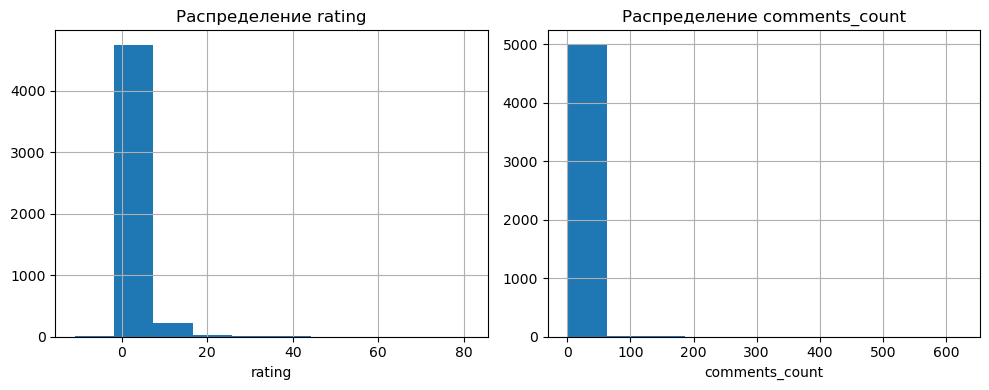

In [255]:
print("Пропуски в comments_count:", df["comments_count"].isna().sum())
print("Пропуски в rating:", df["rating"].isna().sum())

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

df["rating"].hist(ax=axes[0])
axes[0].set_title("Распределение rating")
axes[0].set_xlabel("rating")

df["comments_count"].hist(ax=axes[1])
axes[1].set_title("Распределение comments_count")
axes[1].set_xlabel("comments_count")

plt.tight_layout()
plt.show()

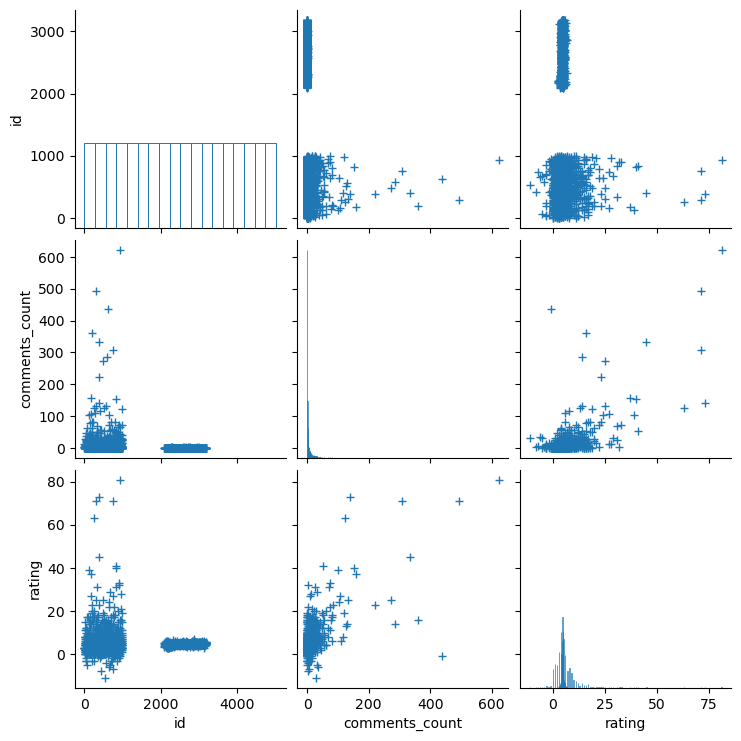

In [239]:
sns.pairplot(
    df,
    plot_kws=dict(marker="+", linewidth=1),
    diag_kws=dict(fill=False),
)

In [241]:
# Заполнили нулем, тк буквально значит, что значений нет
imp_zero = SimpleImputer(strategy="constant", fill_value=0)
zero_col = ["comments_count"]

df[zero_col] = imp_zero.fit_transform(df[zero_col])

In [247]:
imp_knn = KNNImputer(n_neighbors=3)
knn_col = ["rating"]

df[knn_col] = imp_knn.fit_transform(df[knn_col])

In [1201]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5022 entries, 0 to 5021
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   id              5022 non-null   int64              
 1   guid            5022 non-null   object             
 2   title           5022 non-null   object             
 3   description     5022 non-null   object             
 4   url             5022 non-null   object             
 5   published_at    5022 non-null   datetime64[ns, UTC]
 6   comments_count  5022 non-null   float64            
 7   created_at_utc  5022 non-null   datetime64[ns, UTC]
 8   rating          5022 non-null   float64            
dtypes: datetime64[ns, UTC](2), float64(2), int64(1), object(4)
memory usage: 353.2+ KB


## Word2Vec 

Общая схема

- Привести текст к нижнему регистру.

- Оставить только буквы ([А-Яа-яA-Za-z]+).

- Разбить на токены (слова).

- Удалить стоп-слова и короткие токены.

- Для каждого слова получить лемму через pymorphy3.

Так мы уменьшаем размерность словаря и «склеиваем» разные формы слова.

In [258]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alexs\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [269]:
morph = MorphAnalyzer()
RUSSIAN_STOPWORDS = set(stopwords.words("russian"))

TOKEN_RE = re.compile(r"[А-Яа-яA-Za-z]+", flags=re.U)


def preprocess_text(text: str):
    """
    Полная предобработка одного текста:
    - приведение к нижнему регистру,
    - выделение токенов,
    - фильтрация по длине и стоп-словам,
    - лемматизация через pymorphy3.

    Возвращает список лемм (строк).
    """
    if not isinstance(text, str):
        text = "" if text is None else str(text)

    text = text.lower()
    tokens = TOKEN_RE.findall(text)

    lemmas = []
    for token in tokens:
        # Отсекаем короткий мусор
        if len(token) <= 2:
            continue

        # Русские и латинские слова отдельно
        if re.match(r"[а-я]", token):
            # Русское слово: нормальная форма через pymorphy3
            if token in RUSSIAN_STOPWORDS:
                continue
            parsed = morph.parse(token)[0]
            lemma = parsed.normal_form
            if lemma in RUSSIAN_STOPWORDS:
                continue
        else:
            # Латинское/английское слово — оставляем как есть
            lemma = token

        lemmas.append(lemma)

    return lemmas

In [271]:
sample_text = df["description"].iloc[0]
print(sample_text[:100], "...")

preprocess_text(sample_text)[:100]

Доля Intel впервые достигла 1%.

Jon Peddie Research опубликовала отчёт о рынке дискретных видеокарт ...


['доля',
 'intel',
 'впервые',
 'достигнуть',
 'jon',
 'peddie',
 'research',
 'опубликовать',
 'отч',
 'рынок',
 'дискретный',
 'видеокарта',
 'aib',
 'третий',
 'квартал',
 'год',
 'доля',
 'amd',
 'увеличиться',
 'составить',
 'пока',
 'ниже',
 'показатель',
 'первый',
 'квартал',
 'год',
 'intel',
 'прибавить',
 'впервые',
 'достигнуть',
 'отметка',
 'рынок',
 'рост',
 'конкурент',
 'прива',
 'снижение',
 'доля',
 'nvidia',
 'однако',
 'компания',
 'прежний',
 'сохранять',
 'доминировать',
 'положение',
 'согласно',
 'данные',
 'общий',
 'объ',
 'рынок',
 'достигнуть',
 'млрд',
 'поставка',
 'вырасти',
 'млн',
 'единица',
 'сравнение',
 'предыдущий',
 'квартал',
 'ниже',
 'средний',
 'значение',
 'десятилетний',
 'период',
 'квартал',
 'jpr',
 'это',
 'связывать',
 'рекордный',
 'закупка',
 'второй',
 'квартал',
 'который',
 'мочь',
 'связать',
 'повышенный',
 'спрос',
 'фон',
 'ожидать',
 'увеличение',
 'тариф',
 'частично',
 'сократить',
 'объ',
 'закупка',
 'третий',
 'квартал',

In [275]:
N_DOCS = 5022  

texts = df["description"].iloc[:N_DOCS].tolist()

tokenized_texts = [preprocess_text(t) for t in texts]

# Смотрим пример
tokenized_texts[0][:40]

['доля',
 'intel',
 'впервые',
 'достигнуть',
 'jon',
 'peddie',
 'research',
 'опубликовать',
 'отч',
 'рынок',
 'дискретный',
 'видеокарта',
 'aib',
 'третий',
 'квартал',
 'год',
 'доля',
 'amd',
 'увеличиться',
 'составить',
 'пока',
 'ниже',
 'показатель',
 'первый',
 'квартал',
 'год',
 'intel',
 'прибавить',
 'впервые',
 'достигнуть',
 'отметка',
 'рынок',
 'рост',
 'конкурент',
 'прива',
 'снижение',
 'доля',
 'nvidia',
 'однако',
 'компания']

In [279]:
w2v_model = Word2Vec(
    sentences=tokenized_texts,  # список документов, каждый документ = список лемм
    vector_size=120,            # размерность эмбеддинга слова
    window=5,                   # ширина контекста
    min_count=5,                # игнорируем слова реже 5 раз
    workers=4,                  # параллельные потоки
    sg=1,                       # 1 = Skip-gram, 0 = CBOW
    epochs=10,                  # сколько раз пройтись по корпусу
)

w2v_model

In [281]:
w2v_model.wv.most_similar("доля", topn=10)

[('львиный', 0.633039653301239),
 ('соответственно', 0.6106207370758057),
 ('процент', 0.5879350304603577),
 ('вылов', 0.5621820688247681),
 ('рентабельность', 0.5609056353569031),
 ('субарахноидальный', 0.5603248476982117),
 ('капитал', 0.5563032627105713),
 ('домохозяйство', 0.5553101897239685),
 ('пропорционально', 0.5502514839172363),
 ('daly', 0.5502398014068604)]

In [283]:
for test_word in ["наука", "страна", "космос", "владивосток", "война"]:
    if test_word not in w2v_model.wv:
        continue

    print(f"\nПохожие слова для «{test_word}»:")
    for word, score in w2v_model.wv.most_similar(test_word, topn=5):
        print(f"  {word:15s} {score:.3f}")


Похожие слова для «наука»:
  доктор          0.694
  факультет       0.682
  биотехнология   0.675
  социология      0.664
  телемеханика    0.662

Похожие слова для «страна»:
  пакистан        0.611
  дружественный   0.607
  додон           0.593
  беженец         0.591
  индонезия       0.586

Похожие слова для «космос»:
  скафандр        0.708
  околоземный     0.707
  пилотировать    0.704
  межпланетный    0.701
  орбита          0.680

Похожие слова для «владивосток»:
  город           0.678
  уссурийск       0.670
  надеждинский    0.655
  городской       0.626
  посьетский      0.625

Похожие слова для «война»:
  троянский       0.694
  могущественный  0.660
  мститель        0.638
  здный           0.621
  командующий     0.605


In [287]:
def document_vector(tokens, model: Word2Vec):
    """
    Строит вектор документа как среднее по векторам слов.
    Слова, которых нет в модели, игнорируются.
    Если нет ни одного слова, выдаём нулевой вектор.
    """
    vectors = [model.wv[token] for token in tokens if token in model.wv]

    if not vectors:
        return np.zeros(model.vector_size, dtype="float32")

    return np.mean(vectors, axis=0)



doc_vectors = np.vstack([document_vector(tokens, w2v_model) for tokens in tokenized_texts])
doc_vectors.shape

(5022, 120)

In [291]:
doc_vectors[:3]

array([[ 7.72028491e-02, -1.37738258e-01,  2.46229768e-01,
         3.99851650e-02, -8.66201818e-02,  3.15984040e-02,
         2.14471072e-02,  1.96736008e-01, -8.96391720e-02,
         2.18549576e-02,  2.17073441e-01, -4.64005470e-02,
         2.73892522e-01, -8.19204748e-02, -2.24903375e-01,
        -1.67255417e-01,  4.86957695e-04, -2.30198130e-01,
         6.07092120e-03, -1.18838966e-01,  1.24933623e-01,
        -3.37144643e-01,  2.65965044e-01,  4.64104488e-02,
         2.78386120e-02, -1.46232903e-01, -6.44124746e-02,
        -9.21892375e-02, -5.62773831e-02, -6.95522130e-02,
         8.53542238e-02, -1.92083240e-01,  6.16098568e-02,
         5.02082817e-02, -1.20919086e-01,  4.76579703e-02,
         8.04583803e-02, -2.76664644e-01, -4.55564141e-01,
         2.45902136e-01,  4.84905951e-02,  1.34740219e-01,
        -9.57858562e-02, -9.74844620e-02,  1.84492484e-01,
         3.10036451e-01, -1.48638815e-03, -6.97742254e-02,
        -1.86205178e-01,  1.73114359e-01, -2.52526224e-0

## PCA

In [302]:
pca = PCA(n_components=2, random_state=RANDOM_STATE)

doc_vectors_2d = pca.fit_transform(doc_vectors)
doc_vectors_2d[:5]

array([[ 0.01202758, -0.06404158],
       [ 0.4991964 ,  0.07564825],
       [-0.6953598 , -0.6913825 ],
       [-0.3407651 ,  0.04737911],
       [-0.55787194,  0.20893696]], dtype=float32)

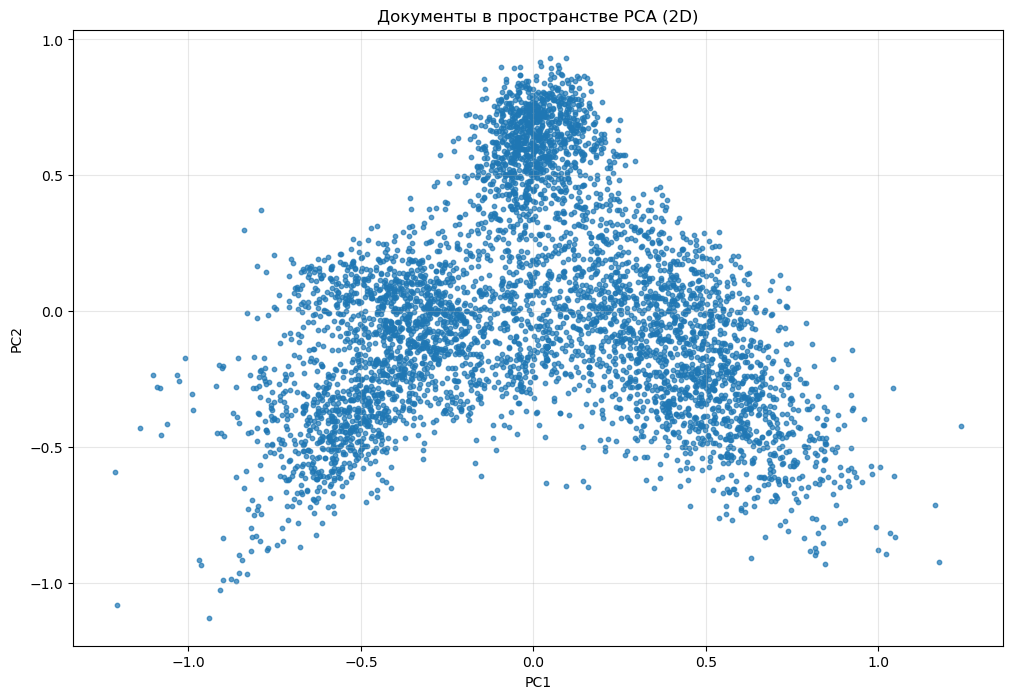

In [306]:
plt.figure(figsize=(12, 8))
plt.scatter(
    doc_vectors_2d[:, 0], 
    doc_vectors_2d[:, 1], 
    alpha=0.7, 
    s=10
)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Документы в пространстве PCA (2D)')
plt.grid(True, alpha=0.3)
plt.show()

In [1003]:
df_subset = df.iloc[:N_DOCS].copy()
df_subset["pca_x"] = doc_vectors_2d[:, 0]
df_subset["pca_y"] = doc_vectors_2d[:, 1]

df_subset.head()

,id,guid,title,description,url,published_at,comments_count,created_at_utc,rating,pca_x,pca_y
0,1505,fef4ca79-8f45-4bd3-8113-ca2f7606a699,AMD и Intel укрепили позиции на рынке видеокар...,Доля Intel впервые достигла 1%.\n\nJon Peddie ...,https://ixbt.games/news/2025/12/02/amd-i-intel...,2025-12-02 00:00:00+00:00,0.0,2025-12-11 12:30:46+00:00,5.357388,0.012028,-0.064042
1,539,f03f799a-f077-40f7-a3dd-cbbe359cb3e6,DeepSeek представила модели V3.2 и V3.2-Specia...,Китайский стартап DeepSeek выпустил очередное ...,https://habr.com/ru/news/972042/,2025-12-01 11:43:25+00:00,20.0,2025-12-11 11:59:58+00:00,7.000000,0.499196,0.075648
2,3553,1562e574-2f81-471d-bcc9-f75600f688c0,В Ереване арестован глава канцелярии духовного...,Правительство Армении поможет в разработке нов...,https://www.interfax.ru/world/1061592,2025-12-05 11:05:00+00:00,0.0,2025-12-11 13:47:10+00:00,5.357388,-0.695360,-0.691383
3,4948,fc71aea7-8759-4ac2-802c-f0b4b67b59b1,Вторую городскую штрафстоянку Владивостока обо...,Администрация Владивостока ищет подрядчика для...,https://www.newsvl.ru/vlad/2025/10/17/234577/,2025-10-17 16:42:00+00:00,0.0,2025-12-11 14:27:35+00:00,5.357388,-0.340765,0.047379
4,4819,36c3e6af-5b48-46c2-a78f-f5f1925402d9,В ночь на понедельник во Владивостоке возможен...,В начале следующей недели погодные условия в П...,https://www.newsvl.ru/vlad/2025/10/26/234734/,2025-10-26 18:59:00+00:00,0.0,2025-12-11 14:24:32+00:00,5.357388,-0.557872,0.208937


## Clustering

In [912]:
X_km = doc_vectors_2d  

In [914]:
inertias = []
silhouettes = []

K = range(2, 16)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_km)

    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_km, kmeans.labels_))

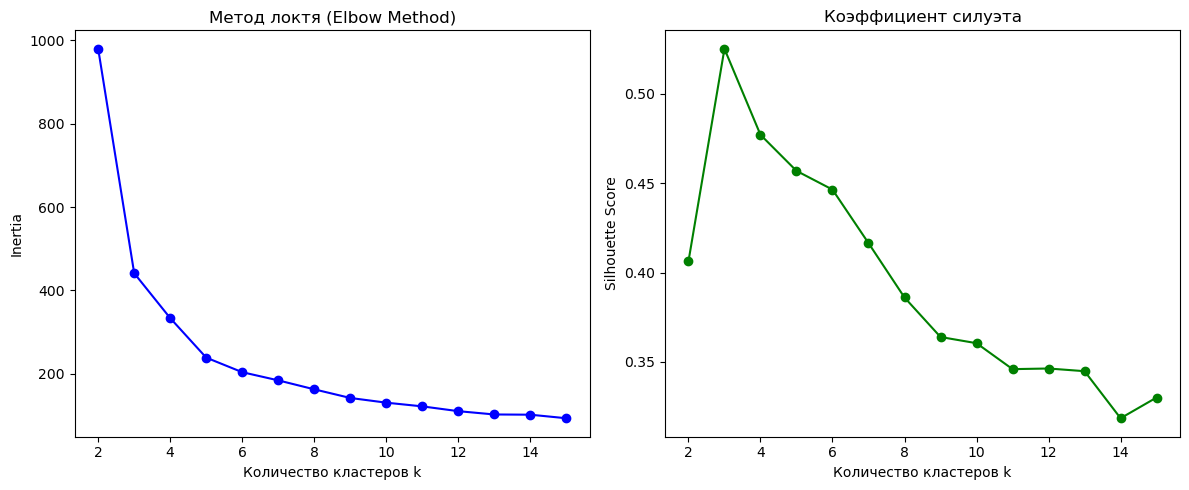

In [915]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(K, inertias, 'bo-')
plt.xlabel('Количество кластеров k')
plt.ylabel('Inertia')
plt.title('Метод локтя (Elbow Method)')

plt.subplot(1,2,2)
plt.plot(K, silhouettes, 'go-')
plt.xlabel('Количество кластеров k')
plt.ylabel('Silhouette Score')
plt.title('Коэффициент силуэта')
plt.tight_layout()
plt.show()

In [1005]:
kmeans_best = KMeans(n_clusters=3, random_state=RANDOM_STATE)
kmeans_best.fit(X_km)

KMeans(n_clusters=3, random_state=42)

In [1007]:
cluster_km = kmeans_best.labels_

df_subset["cluster"] = cluster_km

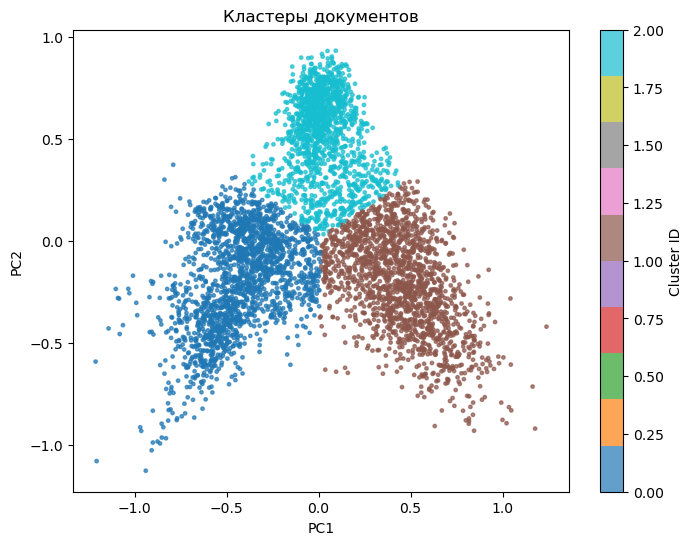

In [926]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    df_subset["pca_x"],
    df_subset["pca_y"],
    c=df_subset["cluster"],
    s=6,
    cmap="tab10",
    alpha=0.7,
)
plt.colorbar(scatter, label="Cluster ID")
plt.title("Кластеры документов")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [1009]:
df_subset["cluster"].value_counts()

cluster
0    1893
1    1723
2    1406
Name: count, dtype: int64

In [1229]:
for i in range(15):
    print(f"{i}. {df_subset[df_subset["cluster"] == 0].iloc[i, 2]}")

0. AMD и Intel укрепили позиции на рынке видеокарт, но NVIDIA всё ещё доминирует — отчёт
1. В Ереване арестован глава канцелярии духовного центра Армянской апостольской церкви
2. Вторую городскую штрафстоянку Владивостока оборудуют на Нефтеветке
3. В ночь на понедельник во Владивостоке возможен небольшой дождь со снегом
4. МИД Израиля сообщил об усилении разногласий с Сирией по соглашению о безопасности
5. В субботу во Владивостоке снова может пойти дождь со снегом
6. Германия в октябре увеличила экспорт в Россию на 4,8%
7. Власти Литвы объявили режим ЧП из-за инцидентов с воздушной контрабандой
8. ГНКАР и катарский UCC Holding создадут СП для поставок топлива в аэропорт Дамаска
9. В Белом доме опровергли наличие документа с идеей создания альтернативы G7 с участием РФ
10. В Киргизии выберут депутатов парламента
11. Трамп назовет кандидата на пост главы ФРС в начале 2026 года
12. С 8 декабря ЦБ отменяет лимиты на переводы за рубеж для граждан РФ и дружественных стран
13. Во Владивосток

In [1231]:
for i in range(15):
    print(f"{i}. {df_subset[df_subset["cluster"] == 1].iloc[i, 2]}")

0. DeepSeek представила модели V3.2 и V3.2-Speciale: новый фокус на reasoning и агентные сценарии
1. Для хоррора «Догони меня, Виталик» вышло сюжетное DLC «Морской Волк» с новой локацией и преследователем
2. Хитовый экшен-платформер Sanabi получил бесплатное дополнение A Haunted Day с новой героиней
3. Google опередил OpenAI в гонке за Пентагон: Gemini развернули для 3 млн военных
4. Решение Micron привело к резкому росту цен. Консоли, смартфоны и ноутбуки подорожают из-за сговора производителей – Gamers Nexus
5. Новая модель ChatGPT будет называться Garlic. Она выйдет на следующей неделе
6. Linux 6.18 официально стал выпуском ядра с долгосрочной поддержкой (LTS)
7. OpenAI запустила сертификационные курсы ИИ для работников
8. Новая надежда для ждущих Леона в Resident Evil Requiem — разработчики подтвердили возвращение персонажей из прошлых частей
9. EvaProject — лучший отечественный аналог Jira по версии портала IaaSSaaSPaaS
10. Анонсировали ретро-шутер Starship Troopers: Ultimate Bug 

In [1232]:
for i in range(15):
    print(f"{i}. {df_subset[df_subset["cluster"] == 2].iloc[i, 2]}")

0. Химик рассказал, что скрывает запах хлорки в бассейне
1. Физики разработали молекулярные кубиты, работающие на частотах мобильной связи
2. Химик рассказала, как продлить жизнь букету цветов
3. Демографы нашли связь между неучастием в выборах и риском смерти от любых причин в дальнейшем
4. Астрономы обнаружили планету, вращающуюся под необычным углом, который никто не может объяснить
5. Китай может обогнать США с высадкой на Луну, и так будет лучше для всего человечества
6. Новая теория раскрыла связь квантовых флуктуаций и судьбы Вселенной
7. Ученые рассказали, какая мука полезнее и почему
8. Ученые в три раза повысили эффективность катализатора для производства водорода
9. Атом протестировал автономное вождение на трассе М-12
10. Биологи перечислили самые убедительные признаки внеземной жизни
11. «Нахожу иероглиф, что я врач, и показываю»: врач из Владивостока по пути из отпуска оказала помощь северокорейской студентке
12. Впервые в истории космонавтики Россия вывела биоспутник на 

In [1011]:
doc_vectors

array([[ 0.07720285, -0.13773826,  0.24622977, ...,  0.06065994,
         0.05713852, -0.2493261 ],
       [ 0.0675484 , -0.06515101,  0.24200071, ..., -0.07486697,
         0.16027059, -0.21460909],
       [-0.19869302, -0.00697113, -0.01628307, ...,  0.08232006,
         0.28828236, -0.3008371 ],
       ...,
       [ 0.10439683, -0.08370173,  0.16813333, ..., -0.03428817,
         0.15704733, -0.3902701 ],
       [-0.05423129, -0.21896079, -0.03657509, ...,  0.02357795,
         0.28141683, -0.2242926 ],
       [ 0.02209398,  0.01606878,  0.176629  , ..., -0.07203289,
         0.17908981, -0.42458355]], dtype=float32)

In [1057]:
y = df_subset["cluster"]

X_numeric = df_subset.select_dtypes(include=["int", "float"])
X_mod = X_numeric.iloc[:, 1:5].values

idx = df_subset.index.to_numpy()
doc_vectors_sup = doc_vectors[idx]

X = np.hstack([doc_vectors_sup, X_mod])

In [1059]:
X.shape

(5022, 124)

In [1065]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

X_train.shape, X_test.shape

((4017, 124), (1005, 124))

## DecisionTreeClassifier

In [1135]:
param_grid_dtc = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

In [1157]:
dtc = DecisionTreeClassifier(random_state=RANDOM_STATE)

grid_search_dtc = GridSearchCV(
    estimator=dtc,
    param_grid=param_grid_dtc,
    cv=5,                    
    scoring='accuracy',     
    n_jobs=-1,               
    verbose=1
)

In [1159]:
grid_search_dtc.fit(X_train, y_train)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7, 10, None],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy', verbose=1)

In [1160]:
print(f"Лучшие параметры: {grid_search_dtc.best_params_}")
print(f"Лучший score: {grid_search_dtc.best_score_:.3f}")

Лучшие параметры: {'criterion': 'entropy', 'max_depth': 7, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10}
Лучший score: 0.990


In [1151]:
best_dtc = grid_search.best_estimator_
test_score_dtc = best_dtc.score(X_test, y_test)

y_pred_dtc = best_dtc.predict(X_test)

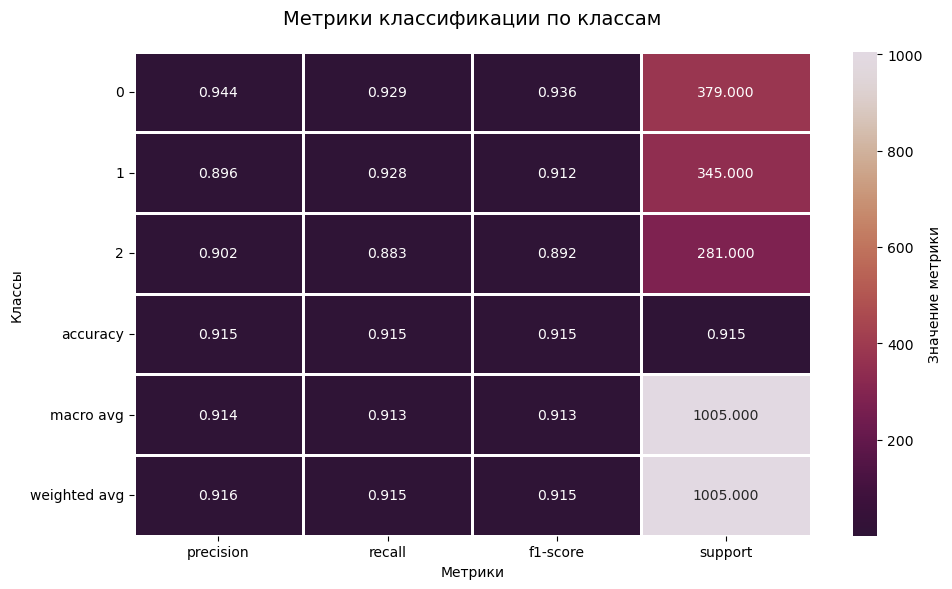

In [1193]:
report_dict = classification_report(y_test, y_pred_dtc, output_dict=True)
metrics_df = pd.DataFrame(report_dict).transpose()

plt.figure(figsize=(10, 6))
sns.heatmap(metrics_df, 
            annot=True, 
            fmt='.3f', 
            cmap='twilight',
            center=0.5,
            linewidths=1,
            cbar_kws={'label': 'Значение метрики'})

plt.title('Метрики классификации по классам', fontsize=14, pad=20)
plt.xlabel('Метрики')
plt.ylabel('Классы')
plt.tight_layout()
plt.show()

## KNeighborsClassifier

In [1168]:
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 10, 15, 20, 30],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

In [1170]:
knn = KNeighborsClassifier()

In [1171]:
grid_search_knn = GridSearchCV(
    knn,
    param_grid=param_grid_knn,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search_knn.fit(X_train, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 7, 10, 15, 20, 30],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=1)

In [1172]:
print(f"Лучшие параметры: {grid_search_knn.best_params_}")
print(f"Лучший CV score: {grid_search_knn.best_score_:.3f}")

Лучшие параметры: {'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'distance'}
Лучший CV score: 0.947


In [1197]:
best_knn = grid_search_knn.best_estimator_

y_pred_knn = best_knn.predict(X_test)

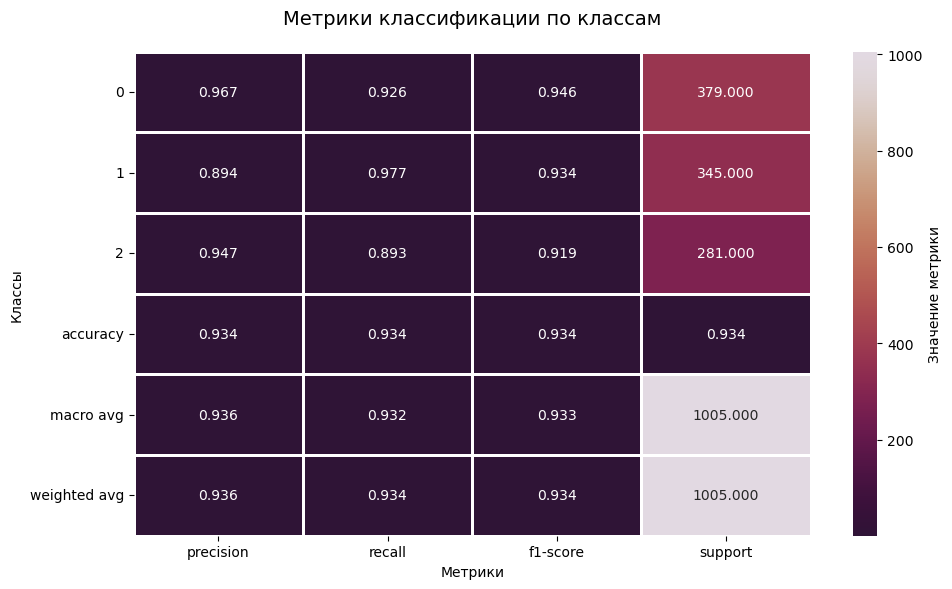

In [1199]:
report_dict = classification_report(y_test, y_pred_knn, output_dict=True)
metrics_df = pd.DataFrame(report_dict).transpose()

plt.figure(figsize=(10, 6))
sns.heatmap(metrics_df, 
            annot=True, 
            fmt='.3f', 
            cmap='twilight',
            center=0.5,
            linewidths=1,
            cbar_kws={'label': 'Значение метрики'})

plt.title('Метрики классификации по классам', fontsize=14, pad=20)
plt.xlabel('Метрики')
plt.ylabel('Классы')
plt.tight_layout()
plt.show()